In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Clean stuff

In [2]:
!rm -rf /kaggle/working/*

# Import libraries and Customize Parameters

In [3]:
# Pip install method (recommended)
%pip install ultralytics
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.0/887.0 kB 19.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Importing the required libraries
from ultralytics import YOLO
import squarify
import matplotlib.pyplot as plt
import cv2
import os
import random
import pandas as pd
import matplotlib.image as mpimg
import seaborn as sns
import torch

sns.set_style('darkgrid')

%matplotlib inline

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
# Check if PyTorch is using the GPU
print("Is CUDA available? ", torch.cuda.is_available())
print("Device name: ", torch.cuda.get_device_name(0))
# Set the device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is on: {device}')

Is CUDA available?  True
Device name:  Tesla P100-PCIE-16GB
Device is on: cuda


# Visualize simple images with annotations

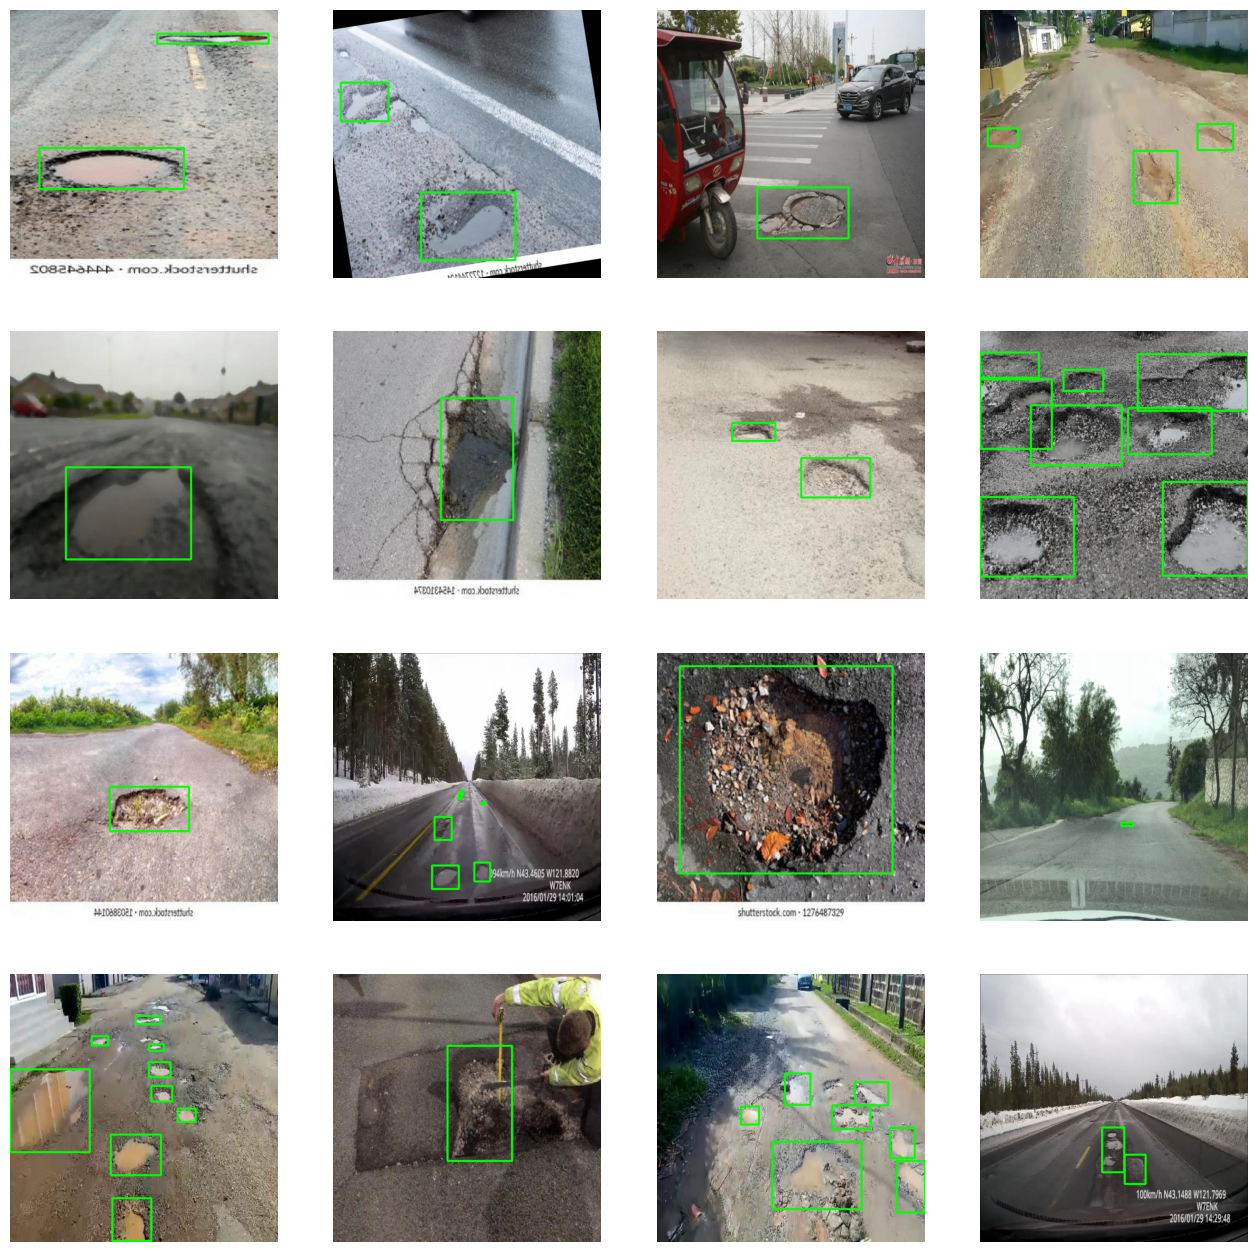

In [6]:
# Define the paths to the images and labels directories
train_images = "/kaggle/input/pothole-dataset/train/images"
train_labels = "/kaggle/input/pothole-dataset/train/labels"

test_images = "/kaggle/input/pothole-dataset/test/images"
test_labels = "/kaggle/input/pothole-dataset/test/images"

val_images = "/kaggle/input/pothole-dataset/valid/images"
val_labels = "/kaggle/input/pothole-dataset/valid/labels"

# Get a list of all the image files in the training images directory
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4
    
    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    # Loop over the labels and plot the object detections
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)


    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

# Show image metadata

In [7]:
# Load an image using OpenCV
image = cv2.imread("/kaggle/input/pothole-dataset/test/images/0004_jpg.rf.f92ab952cd8544f887caf35fcccbcd10.jpg")

# Get the size of the image
height, width, channels = image.shape
print(f"The image has dimensions {width}x{height} and {channels} channels.")

The image has dimensions 640x640 and 3 channels.


# Model Training

In [8]:
# Loading a pretrained model
model = YOLO('yolo11n.pt')

# free up GPU memory
torch.cuda.empty_cache()

# Training the model
model.train(data = '/kaggle/input/pothole-dataset/data.yaml',
            epochs = 20,
            imgsz = (height, width, channels),
            seed = 42,
            batch = 8,
            workers = 4)

100%|██████████| 5.35M/5.35M [00:00<00:00, 98.5MB/s]


Ultralytics 8.3.32 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/pothole-dataset/data.yaml, epochs=20, time=None, patience=100, batch=8, imgsz=(640, 640, 3), save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tru

100%|██████████| 755k/755k [00:00<00:00, 19.9MB/s]
2024-11-17 22:38:33,311	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-17 22:38:33,835	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/input/pothole-dataset/train/labels... 11068 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11068/11068 [00:33<00:00, 334.62it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/pothole-dataset/train is not writeable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 3815, len(boxes) = 29161. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/pothole-dataset/valid/labels... 1808 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1808/1808 [00:05<00:00, 341.54it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/pothole-dataset/valid is not writeable, cache not saved.
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.47G      1.792      2.146      1.667          4        640: 100%|██████████| 1384/1384 [03:28<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:12<00:00,  8.72it/s]


                   all       1808       4487      0.516      0.417      0.418       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.48G      1.823      1.887       1.71          6        640: 100%|██████████| 1384/1384 [03:16<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:11<00:00,  9.55it/s]


                   all       1808       4487      0.518      0.405      0.403      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       1.5G      1.784      1.815      1.675          4        640: 100%|██████████| 1384/1384 [03:13<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:11<00:00,  9.63it/s]


                   all       1808       4487      0.567       0.48      0.487      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.48G      1.744      1.726      1.654         11        640: 100%|██████████| 1384/1384 [03:11<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:11<00:00,  9.84it/s]


                   all       1808       4487      0.627      0.476      0.523      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.47G        1.7      1.649      1.614          5        640: 100%|██████████| 1384/1384 [03:11<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:11<00:00,  9.63it/s]


                   all       1808       4487      0.636      0.503      0.552      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       1.5G      1.661      1.586      1.589         15        640: 100%|██████████| 1384/1384 [03:11<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:11<00:00,  9.83it/s]

                   all       1808       4487      0.675      0.546      0.603      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.47G      1.652      1.559      1.581         10        640: 100%|██████████| 1384/1384 [03:11<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:11<00:00,  9.54it/s]


                   all       1808       4487      0.667       0.52       0.58      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.47G      1.625      1.512      1.566         37        640: 100%|██████████| 1384/1384 [03:11<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:11<00:00,  9.75it/s]


                   all       1808       4487      0.703      0.571       0.63      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.47G        1.6      1.472      1.546          6        640: 100%|██████████| 1384/1384 [03:11<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:11<00:00,  9.53it/s]


                   all       1808       4487      0.671      0.588       0.64      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.47G      1.582      1.456      1.531         30        640: 100%|██████████| 1384/1384 [03:11<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:11<00:00,  9.68it/s]


                   all       1808       4487      0.688      0.571      0.633      0.328
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.47G      1.572      1.334      1.538          4        640: 100%|██████████| 1384/1384 [03:10<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:11<00:00,  9.92it/s]


                   all       1808       4487      0.711      0.593      0.657      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.49G      1.536      1.273       1.51          6        640: 100%|██████████| 1384/1384 [03:09<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:11<00:00,  9.65it/s]


                   all       1808       4487      0.714       0.61      0.683       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.47G      1.508      1.239      1.493          7        640: 100%|██████████| 1384/1384 [03:08<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:11<00:00,  9.85it/s]

                   all       1808       4487      0.696      0.615      0.676       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.47G      1.491      1.199      1.479          7        640: 100%|██████████| 1384/1384 [03:08<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:11<00:00,  9.91it/s]


                   all       1808       4487      0.738       0.61      0.704      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.47G      1.464      1.161       1.46          8        640: 100%|██████████| 1384/1384 [03:09<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:11<00:00,  9.75it/s]


                   all       1808       4487      0.749      0.623      0.711      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.47G       1.44      1.135      1.442         13        640: 100%|██████████| 1384/1384 [03:08<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:11<00:00,  9.68it/s]

                   all       1808       4487      0.742      0.654      0.725      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.47G      1.423      1.104      1.429         18        640: 100%|██████████| 1384/1384 [03:08<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:11<00:00,  9.87it/s]


                   all       1808       4487      0.747      0.653      0.733      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.47G      1.398      1.075      1.408         11        640: 100%|██████████| 1384/1384 [03:08<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:11<00:00,  9.81it/s]


                   all       1808       4487      0.755      0.667      0.744      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.47G      1.376      1.035      1.387          9        640: 100%|██████████| 1384/1384 [03:09<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:11<00:00,  9.61it/s]

                   all       1808       4487      0.748      0.668      0.746       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.47G      1.356      1.013      1.378         11        640: 100%|██████████| 1384/1384 [03:08<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:11<00:00, 10.04it/s]

                   all       1808       4487      0.766      0.677      0.753      0.428



20 epochs completed in 1.137 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.32 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:12<00:00,  8.78it/s]


                   all       1808       4487      0.766      0.678      0.754      0.428
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x787f1119b9a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Model Performance

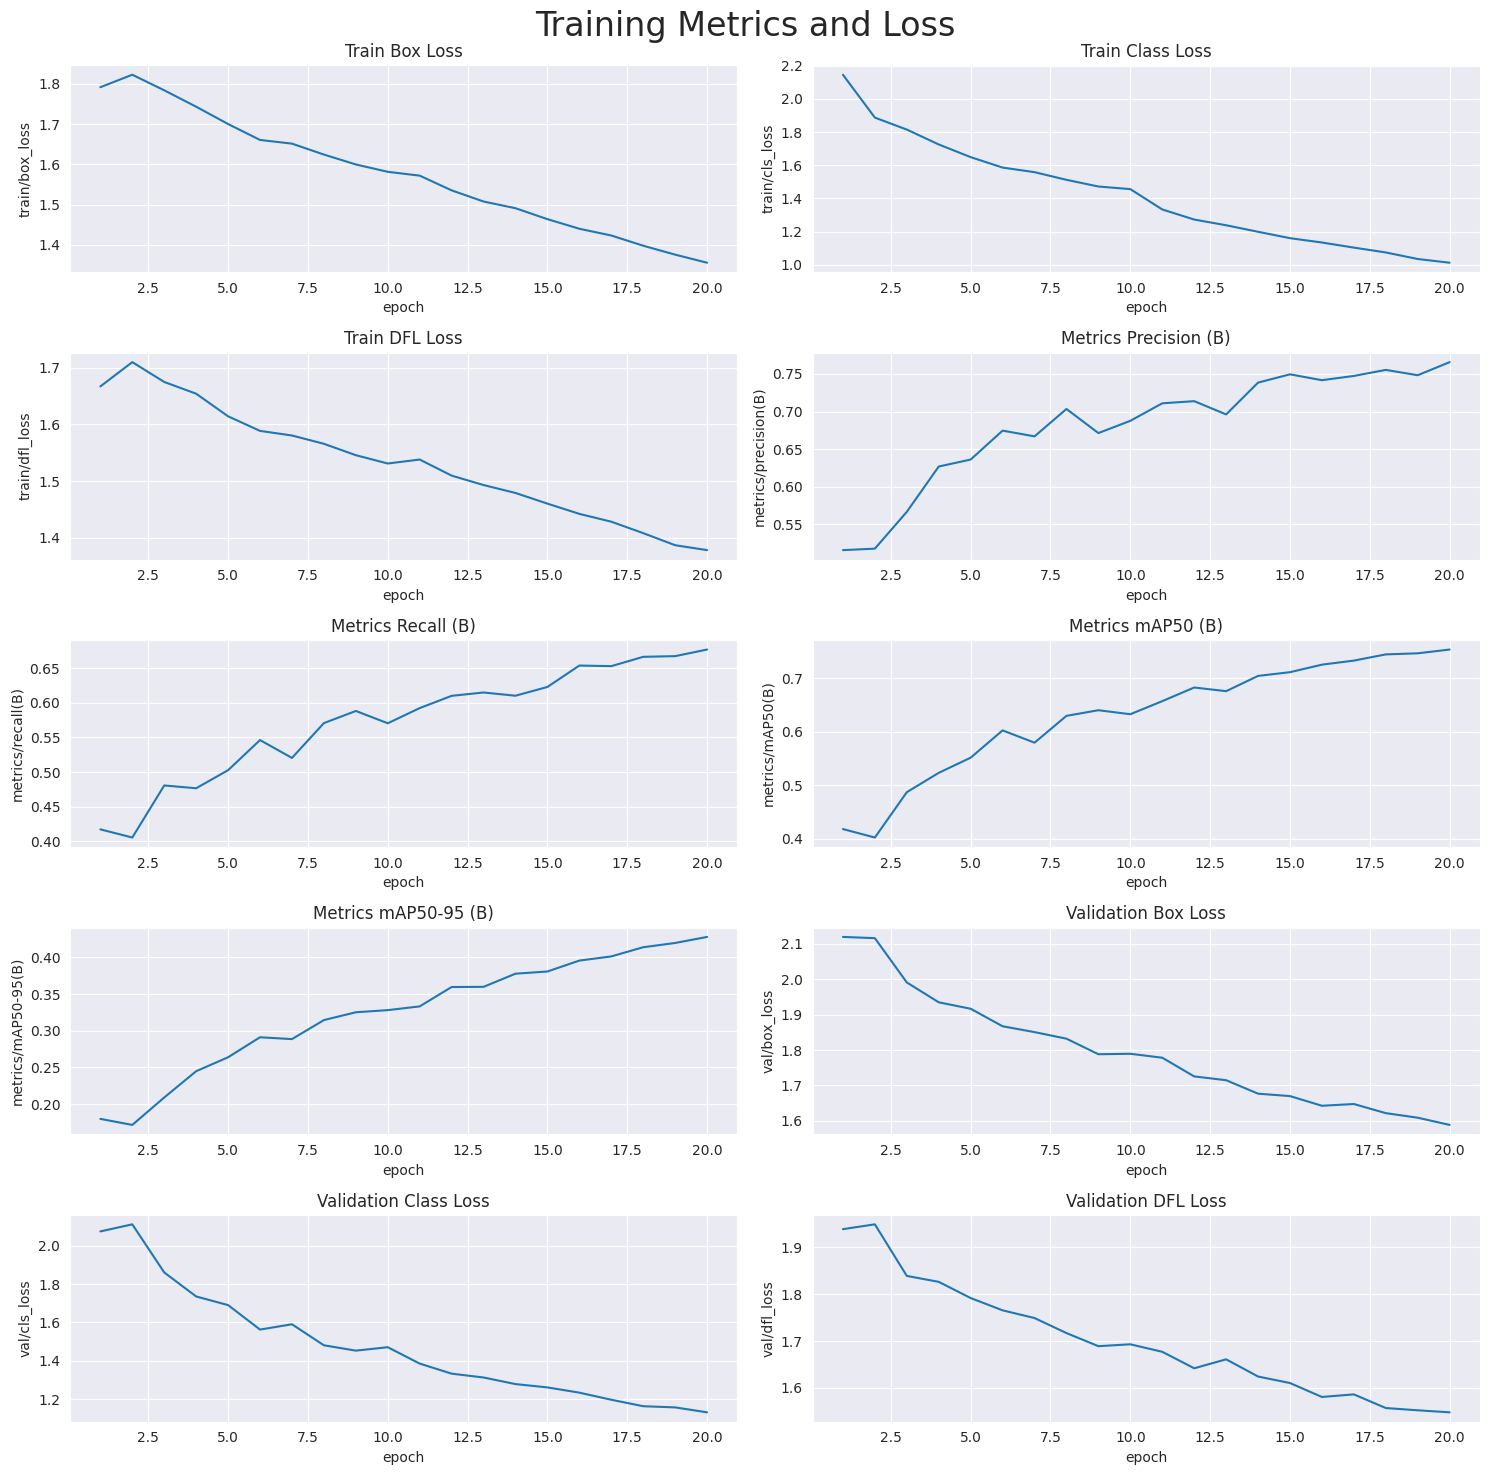

In [9]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/runs/detect/train/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

# Model Evaluation

In [10]:
%matplotlib inline
# Loading the best performing model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25, split = 'test')

Ultralytics 8.3.32 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/input/pothole-dataset/test/labels... 891 images, 0 backgrounds, 0 corrupt: 100%|██████████| 891/891 [00:03<00:00, 291.66it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/pothole-dataset/test is not writeable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 8, len(boxes) = 2171. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:06<00:00,  8.28it/s]


                   all        891       2171      0.782      0.698      0.779      0.504
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val


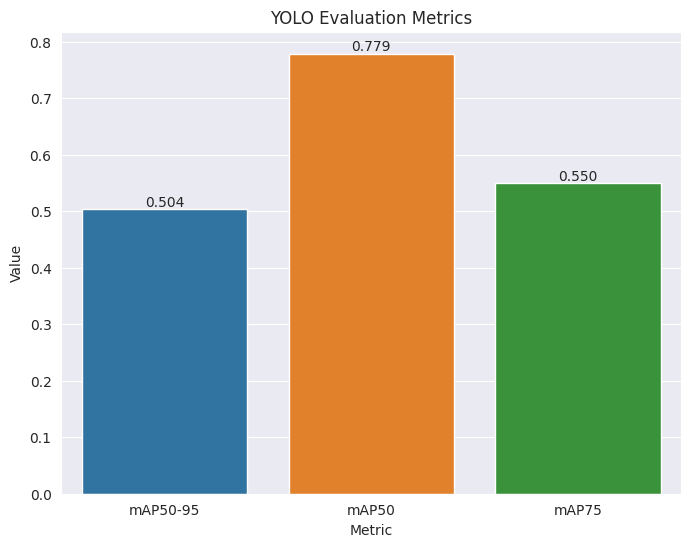

In [11]:
%matplotlib inline
# Create the barplot
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

# Set the title and axis labels
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    
# Show the plot
plt.show()


## Confusion Matrix

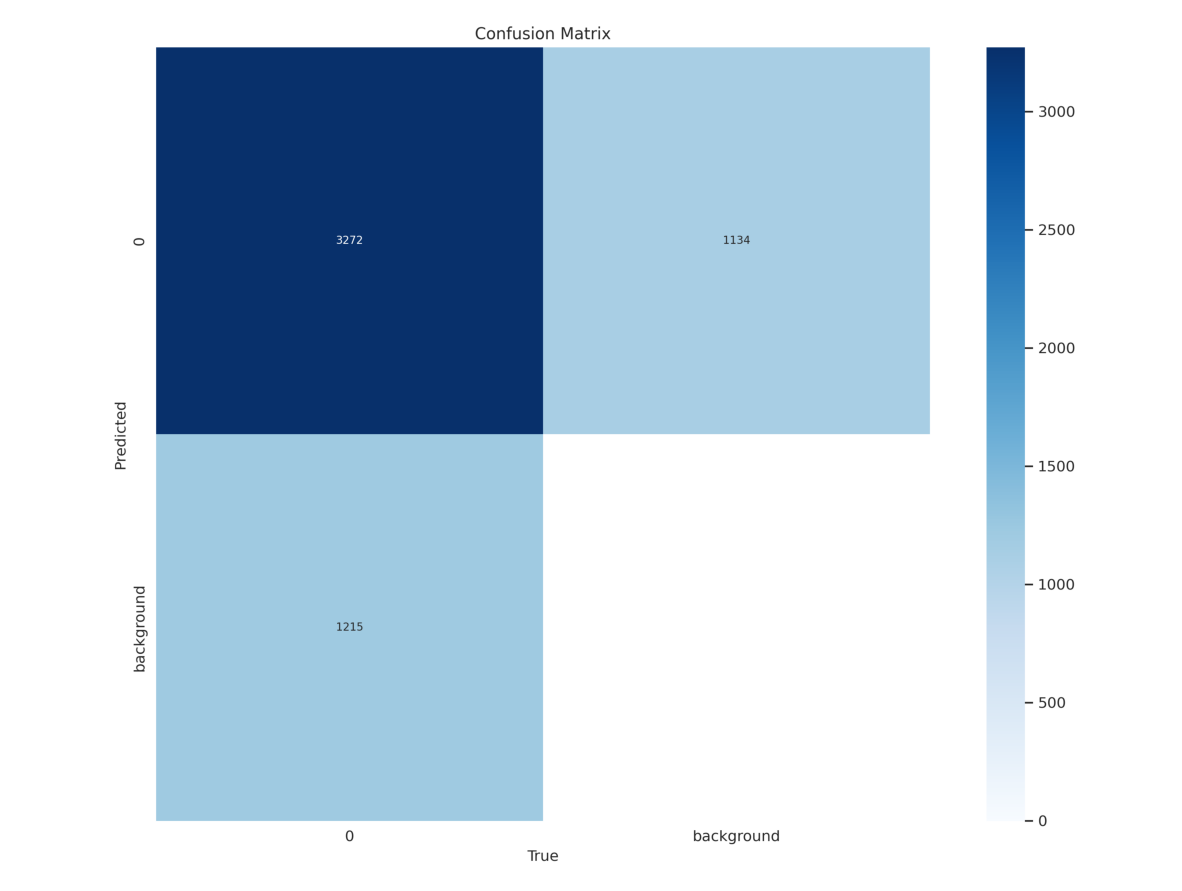

In [12]:
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/train/confusion_matrix.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off');

# Making Predictions on Test Images

In [13]:
# Function to perform ship detections
def pothole_detect(img_path):
    
    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)

    # Plot the detections
    detect_img = detect_result[0].plot()
    
    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    
    return detect_img


0: 640x640 1 0, 12.2ms
Speed: 1.7ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 0s, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 8.9ms
Speed: 1.7ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 8.7ms
Speed: 2.0ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 8.5ms
Speed: 1.6ms preprocess, 8.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 0s, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 0s, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 0s, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 8.2ms
Speed: 1.8ms prepro

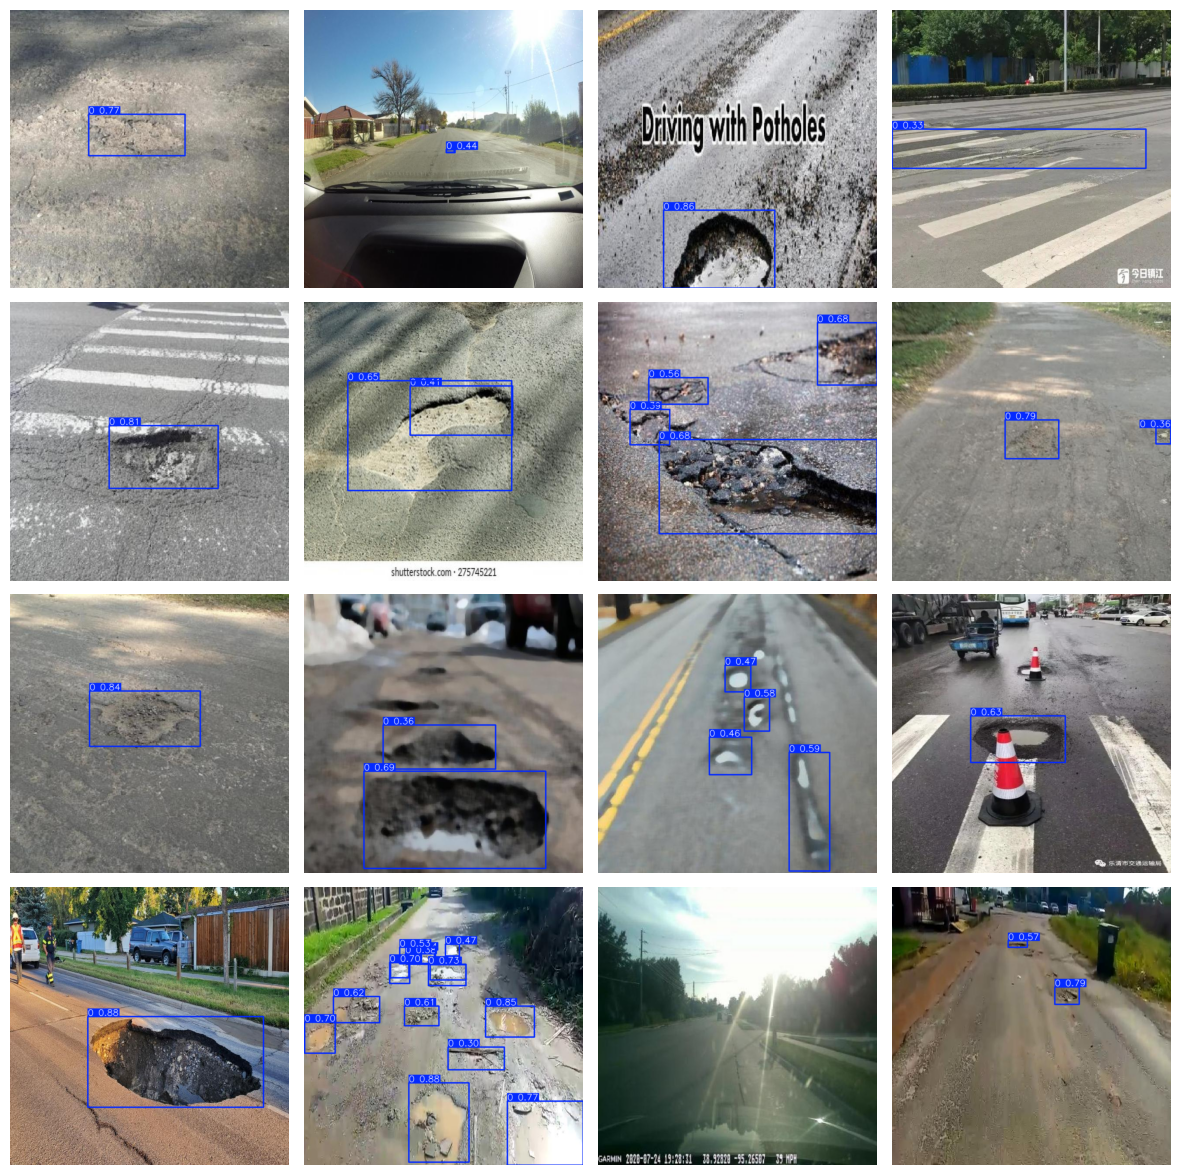

In [14]:
import random

# Define the directory where the custom images are stored
custom_image_dir = '/kaggle/input/pothole-dataset/test/images'

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 16)

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):
    
    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4
    
    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = pothole_detect(img_path)
    
    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Download train results and model

In [15]:
# zip the test results folder
!zip -r yolo_training_results.zip /kaggle/working/runs

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/detect/ (stored 0%)
  adding: kaggle/working/runs/detect/train/ (stored 0%)
  adding: kaggle/working/runs/detect/train/R_curve.png (deflated 16%)
  adding: kaggle/working/runs/detect/train/confusion_matrix.png (deflated 38%)
  adding: kaggle/working/runs/detect/train/confusion_matrix_normalized.png (deflated 39%)
  adding: kaggle/working/runs/detect/train/F1_curve.png (deflated 16%)
  adding: kaggle/working/runs/detect/train/labels.jpg (deflated 26%)
  adding: kaggle/working/runs/detect/train/train_batch1.jpg (deflated 2%)
  adding: kaggle/working/runs/detect/train/train_batch0.jpg (deflated 2%)
  adding: kaggle/working/runs/detect/train/events.out.tfevents.1731883126.998fff8ef5a8.23.0 (deflated 93%)
  adding: kaggle/working/runs/detect/train/train_batch13842.jpg (deflated 10%)
  adding: kaggle/working/runs/detect/train/train_batch13841.jpg (deflated 6%)
  adding: kaggle/working/runs/detect/train/args.yaml (deflat

In [16]:
!mkdir /kaggle/output/
!mv yolo_training_results.zip /kaggle/output/